### Unveiling Causal Inference Techniques: A Guide for Data Scientists
In data science, understanding causality is crucial for making accurate predictions and taking effective actions. 
However, inferring causality from observational data can be a complex and challenging task. 
This post explores several causal inference techniques for when running a Randomize Controlled Test isn't feasible.

#### Problem Statement:
Facebook has introduced a new feature called "Daily Stories" that highlights trending posts and stories personalized for each user. The goal is to evaluate whether this new feature increases overall user engagement on the platform.

#### Approach:
We will use a combination of Diff-in-Diff (DiD), Propensity Score Matching (PSM), and Matched Pairs techniques to analyze the causal impact of the new feature on user engagement.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Generate dummy data
n_users = 1000
users = pd.DataFrame({
    'user_id': range(1, n_users + 1),
    'age': np.random.randint(18, 60, size=n_users),
    'gender': np.random.choice(['Male', 'Female'], size=n_users),
    'region': np.random.choice(['North America', 'Europe', 'Asia', 'South America', 'Africa'], size=n_users),
    'prior_engagement': np.random.normal(50, 10, size=n_users)  # Prior engagement score
})

# Assign treatment (new feature)
users['treatment'] = np.random.choice([0, 1], size=n_users)

# Generate engagement scores before and after the feature launch
users['engagement_pre'] = users['prior_engagement'] + np.random.normal(0, 5, size=n_users)
users['engagement_post'] = users['engagement_pre'] + users['treatment'] * np.random.normal(5, 2, size=n_users) + np.random.normal(0, 5, size=n_users)

# Check the generated data
users.head()

,user_id,age,gender,region,prior_engagement,treatment,engagement_pre,engagement_post
0,1,54,Female,South America,47.825700,1,59.729978,56.164603
1,2,49,Male,North America,49.009599,0,41.911780,40.785871
2,3,24,Male,Europe,43.677648,1,39.895371,39.418769
3,4,35,Female,South America,40.218743,1,52.183501,63.909185
4,5,36,Male,Europe,41.535214,1,49.242820,57.914590


### Exploratory Data Analysis (EDA)

In [2]:
# Summary statistics
users.describe()

,user_id,age,prior_engagement,treatment,engagement_pre,engagement_post
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,500.500000,37.944000,49.908087,0.513000,49.859656,52.454100
std,288.819436,12.328214,9.931322,0.500081,11.072693,12.265754
min,1.000000,18.000000,11.823360,0.000000,4.688172,3.897113
25%,250.750000,27.000000,43.401276,0.000000,42.226545,44.217501
50%,500.500000,37.000000,49.940079,1.000000,49.738285,52.404158
75%,750.250000,49.000000,56.287265,1.000000,57.012112,60.078499
max,1000.000000,59.000000,84.661598,1.000000,82.042582,90.772615


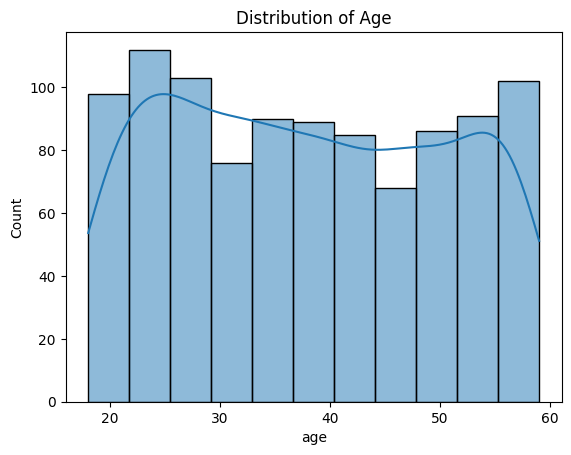

In [3]:
# Distribution of age
sns.histplot(users['age'], kde=True)
plt.title('Distribution of Age')
plt.show()

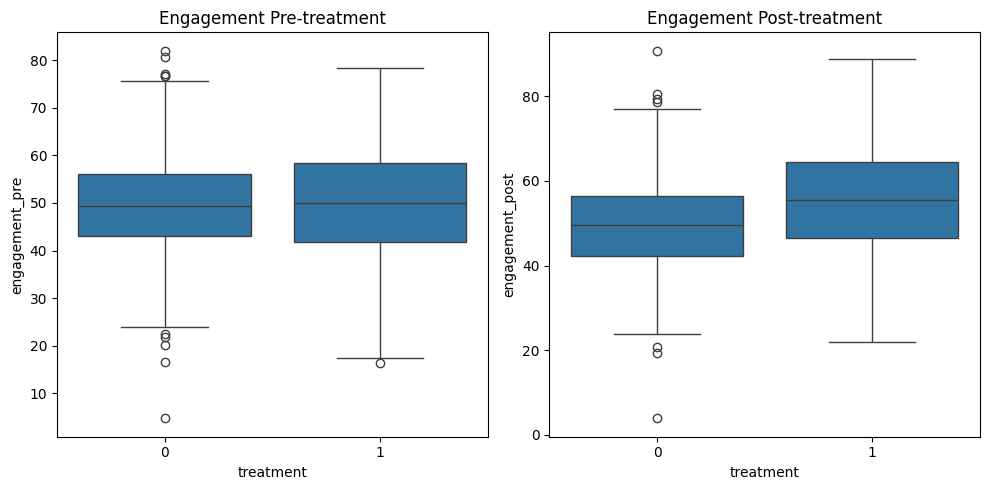

In [4]:
# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Engagement Pre-treatment
sns.boxplot(x='treatment', y='engagement_pre', data=users, ax=axes[0])
axes[0].set_title('Engagement Pre-treatment')

# Engagement Post-treatment
sns.boxplot(x='treatment', y='engagement_post', data=users, ax=axes[1])
axes[1].set_title('Engagement Post-treatment')

# Display the plots
plt.tight_layout()
plt.show()

### Propensity Score Matching (PSM)
Helps to identify a balanced comparison of users by estimating the probability of a user receiving the treatment based on observed characteristics.

In [5]:
# Encode categorical variables
users_encoded = pd.get_dummies(users, columns=['gender', 'region'], drop_first=True)
users_encoded.head(2)

,user_id,age,prior_engagement,treatment,engagement_pre,engagement_post,gender_Male,region_Asia,region_Europe,region_North America,region_South America
0,1,54,47.825700,1,59.729978,56.164603,False,False,False,False,True
1,2,49,49.009599,0,41.911780,40.785871,True,False,False,True,False


In [6]:
# Estimate propensity scores
X = users_encoded[['age', 'gender_Male', 'region_Europe', 'region_Asia', 'region_South America', 'prior_engagement']]
y = users_encoded['treatment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

# Predict propensity scores
users['propensity_score'] = log_reg.predict_proba(X)[:, 1]

In [7]:
# Match users
from sklearn.neighbors import NearestNeighbors

# Find nearest neighbors based on propensity scores
nn = NearestNeighbors(n_neighbors=1)
nn.fit(users[users['treatment'] == 0]['propensity_score'].values.reshape(-1, 1))

distances, indices = nn.kneighbors(users[users['treatment'] == 1]['propensity_score'].values.reshape(-1, 1))
matched_control_indices = users[users['treatment'] == 0].iloc[indices.flatten()].index
matched_control = users.loc[matched_control_indices]



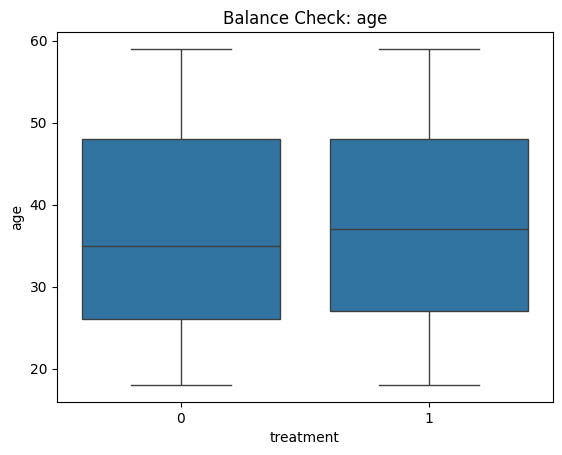

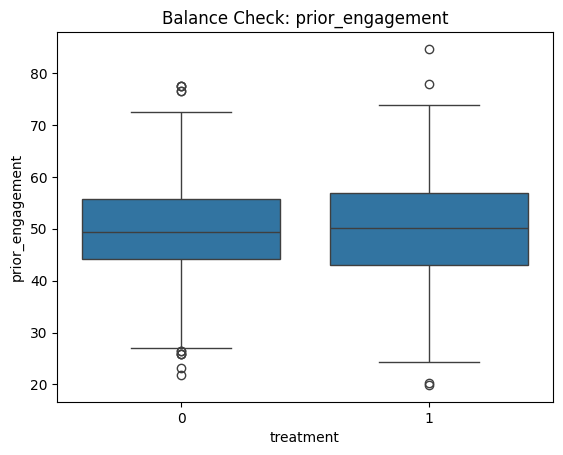

In [8]:
# Create matched sample
matched_treatment = users[users['treatment'] == 1]
matched_sample = pd.concat([matched_treatment, matched_control])

# Check balance
for col in ['age', 'prior_engagement']:
    sns.boxplot(x='treatment', y=col, data=matched_sample)
    plt.title(f'Balance Check: {col}')
    plt.show()

This check balance stage is crucial This step is crucial because it helps mitigate the risk of bias due to confounding variables, ensuring that any differences observed in outcomes can be more confidently attributed to the treatment (new feature) rather than to pre-existing differences between groups.

### Diff-in-Diff Analysis
A statistical technique used to estimate the causal effect of a treatment or intervention by comparing the changes in outcomes over time between a treatment group and a control group.

In [9]:
# Calculate pre-post differences
matched_sample['engagement_diff'] = matched_sample['engagement_post'] - matched_sample['engagement_pre']

# Calculate DiD estimator
did_estimator = matched_sample[matched_sample['treatment'] == 1]['engagement_diff'].mean() - matched_sample[matched_sample['treatment'] == 0]['engagement_diff'].mean()

print(f'Diff-in-Diff Estimator: {did_estimator}')


Diff-in-Diff Estimator: 5.437427093535982


### Matched Pairs Analysis
Matched Pairs is a method of pairing treated and control units that are similar in terms of observed characteristics to reduce confounding bias in causal inference.

In [10]:
# Pair users within the matched sample
matched_pairs = matched_sample.groupby('propensity_score').apply(lambda x: x.sample(n=2, replace=True))
# Reset index to avoid ambiguity
matched_pairs = matched_pairs.reset_index(drop=True)

In [11]:
# Compare engagement levels within pairs
pairwise_diffs = matched_pairs.groupby('propensity_score').apply(lambda x: x.iloc[0]['engagement_post'] - x.iloc[1]['engagement_post'])
# Estimate treatment effect
treatment_effect = pairwise_diffs.mean()

In [14]:
print(f'Matched Pairs Treatment Effect: {treatment_effect}')

Matched Pairs Treatment Effect: 1.23
